# Get from Address to Model

In [1]:
import urllib
import requests
import json

## Geo-Admin API
Access of the API

In [2]:
#Definition of parameters
text = input("Please enter an address: ") #Input of the address to search for
base_url="https://api3.geo.admin.ch/rest/services/api/SearchServer?"
parameters = {"searchText": text, "origins": "address", "type": "locations",}

#Request
r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")

data = json.loads(r.content)
#print(data)

Geographic display of returned results

In [3]:
import folium

# Create a map centered at the first item's latitude and longitude
map_center = [data['results'][0]['attrs']['lat'], data['results'][0]['attrs']['lon']]
m = folium.Map(location=map_center, zoom_start=20)

# Add markers for each item with annotations
for i, result in enumerate(data['results']):
    lat = result['attrs']['lat']
    lon = result['attrs']['lon']
    label = f"Index: {i}"
    folium.Marker([lat, lon], popup=label).add_to(m)

# Display the map
m


In [4]:
#Select the desired item
index = int(input("Please enter the index of the item you want to select: "))
selected_building = data['results'][index]
#print(selected_building)


## KML files
Check KML files for desired building

In [5]:
import os
import re
import math

# Define the folder path
folder_path = "swissBUILDINGS3D"

# Get the latitude and longitude from the selected_item
lat = float(selected_building['attrs']['lat'])
lon = float(selected_building['attrs']['lon'])
print(f"Latitude: {lat}", f"Longitude: {lon}")

# Define the calculate_distance function
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Earth radius in kilometers

    return distance

# Search for KML files in the folder
kml_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".kml"):
            kml_files.append(os.path.join(root, file))

print(f"Found {len(kml_files)} KML files", kml_files)

# Define the tolerance in kilometers
tolerance = 0.01

# List to store the filtered KML data
filtered_kml_data = []

# Iterate through the KML files
for kml_file in kml_files:
    with open(kml_file, 'r') as file:
        kml_content = file.read()
        
        # Extract the latitude and longitude values from the KML content
        latitudes = re.findall(r'<latitude>(.*?)</latitude>', kml_content)
        longitudes = re.findall(r'<longitude>(.*?)</longitude>', kml_content)
        hrefs = re.findall(r'<href>(.*?)</href>', kml_content)
        
        # Convert the latitude and longitude values to float
        latitudes = [float(lat) for lat in latitudes]
        longitudes = [float(lon) for lon in longitudes]
        
        # Check if any entry is within the tolerance
        for i in range(len(latitudes)):
            distance = calculate_distance(lat, lon, latitudes[i], longitudes[i])
            if distance <= tolerance:
                filtered_kml_data.append((kml_file, latitudes[i], longitudes[i],  hrefs[i]))

# Print the filtered KML data
#for data in filtered_kml_data:
    #print(f"KML File: {data[0]}, Latitude: {data[1]}, Longitude: {data[2]}, href: {data[3]}")



Latitude: 47.63731002807617 Longitude: 8.693245887756348
Found 6 KML files ['swissBUILDINGS3D\\1031-44\\1031-44.kml', 'swissBUILDINGS3D\\1032-33\\1032-33.kml', 'swissBUILDINGS3D\\1032-34\\1032-34.kml', 'swissBUILDINGS3D\\1051-22\\1051-22.kml', 'swissBUILDINGS3D\\1052-11\\1052-11.kml', 'swissBUILDINGS3D\\1052-12\\1052-12.kml']


## Get model data from kml

In [6]:
import collada

kml = filtered_kml_data[0][0].split("\\")[1]
model = filtered_kml_data[0][3].split("/")[-1]

for data in filtered_kml_data:
    kml_file = data[0]
    lat = data[1]
    lon = data[2]
    href = data[3]
    
    # Load the COLLADA file
    coll = collada.Collada("swissBUILDINGS3D\\"+kml+"\\models\\"+model)
    #print ("swissBUILDINGS3D\\"+kml+"\\models\\"+model)
    # Extract the geometry
    #print(coll)
    #print(coll.geometries)
    #print(coll.geometries[0].primitives)
    #for i in coll.geometries[0].primitives[0]:
        #print(i)


In [7]:
import numpy as np
from ipygany import PolyMesh

meshes=[]

for i in range(len(coll.geometries)):
    
    vertices = []
    faces = []

    for triangle in coll.geometries[i].primitives[0]:
        # Extract the vertices of the triangle
        v1, v2, v3 = triangle.vertices
        
        # Add the vertices to the vertices list
        vertices.append(v1)
        vertices.append(v2)
        vertices.append(v3)
        
        # Calculate the indices of the vertices in the faces list
        index1 = len(vertices) - 3
        index2 = len(vertices) - 2
        index3 = len(vertices) - 1
        
        # Add the indices to the faces list
        faces.append([index1, index2, index3])

    # Convert the vertices and faces lists to numpy arrays
    vertices = np.array(vertices)
    faces = np.array(faces)

    # Create the PolyMesh
    mesh = PolyMesh(vertices=vertices, triangle_indices=faces)
    meshes.append(mesh)

#print(meshes[0].vertices)


In [8]:
#Draw the whole building
from ipygany import Scene

sceneHouse = Scene(meshes)
sceneHouse

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [9]:
walls = [mesh for mesh in meshes if (mesh.vertices[2::3].max()- mesh.vertices[2::3].min())> 6]

sceneWalls = Scene(walls)
sceneWalls


Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [10]:
roof = [mesh for mesh in meshes if not (mesh.vertices[2::3].max()- mesh.vertices[2::3].min())> 6]

sceneRoof = Scene(roof)
sceneRoof

Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [11]:
num_triangles = len(walls[0].vertices)/9
ns_walls, we_walls = [], []
ns_vertices, we_vertices = [], []
ns_faces, we_faces = [], []
triangles = []
ns_index=0
we_index=0
for i in range(int(num_triangles)):
    triangle= walls[0].vertices[i*9:(i+1)*9]
    triangles.append(triangle)
for triangle in triangles:
    x1, y1, z1 = triangle[0], triangle[1], triangle[2]
    x2, y2, z2 = triangle[3], triangle[4], triangle[5]
    x3, y3, z3 = triangle[6], triangle[7], triangle[8]

    dir12 = np.array([abs(x2 - x1), abs(y2 - y1)])
    dir13 = np.array([abs(x3 - x1), abs(y3 - y1)])
    dir23 = np.array([abs(x3 - x2), abs(y3 - y2)])

    if(max(dir12[0], dir13[0], dir23[0])>max(dir12[1],dir13[1],dir23[1])):
        ns_vertices.append(triangle)
        ns_faces.append([ns_index, ns_index+1, ns_index+2])
        ns_index+=3

    else:
        we_vertices.append(triangle)
        we_faces.append([we_index, we_index+1, we_index+2])
        we_index+=3

ns_walls.append(PolyMesh(vertices=ns_vertices, triangle_indices=ns_faces))
we_walls.append(PolyMesh(vertices=we_vertices, triangle_indices=we_faces))

print(we_walls)

sceneNS =Scene(we_walls)
sceneNS


[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), vertices=array([  5.079199  ,   5.4862475 , 443.437     ,   3.2916253 ,
        -0.73546433, 447.441     ,   1.3663403 ,  -7.4389973 ,
       442.796     ,   5.079199  ,   5.4862475 , 433.596     ,
         1.3663403 ,  -7.4389973 , 442.796     ,   1.3663403 ,
        -7.4389973 , 433.596     ,   5.079199  ,   5.4862475 ,
       443.437     ,   1.3663403 ,  -7.4389973 , 442.796     ,
         5.079199  ,   5.4862475 , 433.596     ,  -2.6901932 ,
        -6.272075  , 442.797     ,  -2.3396606 ,  -5.0516224 ,
       443.643     ,  -2.3396606 ,  -5.0516224 , 433.596     ,
        -2.6901932 ,  -6.272075  , 442.797     ,  -2.3396606 ,
        -5.0516224 , 433.596     ,  -2.6901932 ,  -6.272075  ,
       433.596     ], dtype=float32))]


Scene(children=[PolyMesh(data=[], triangle_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, …

In [12]:
wallsNS2D, wallsWE2D = [], []
for i in range(len(ns_walls[0].vertices)):
    if not i % 3 == 2:
        wallsNS2D.append(ns_walls[0].vertices[i])

for i in range(len(we_walls[0].vertices)):
    if not i % 3 == 2:
        wallsWE2D.append(we_walls[0].vertices[i])


print(wallsNS2D)
print(wallsWE2D)

[0.5388451, 6.790912, 5.079199, 5.4862475, 0.5388611, 6.791912, 5.079199, 5.4862475, 5.079199, 5.4862475, 0.5388451, 6.790912, -2.8254488, -4.9118476, -2.3396606, -5.0516224, -2.3396606, -5.0516224, -2.8254488, -4.9118476, -2.3396606, -5.0516224, -2.8254488, -4.9118476, 1.3663403, -7.4389973, -2.6901932, -6.272075, -2.6901932, -6.272075, 1.3663403, -7.4389973, -2.6901932, -6.272075, 1.3663403, -7.4389973]
[5.079199, 5.4862475, 3.2916253, -0.73546433, 1.3663403, -7.4389973, 5.079199, 5.4862475, 1.3663403, -7.4389973, 1.3663403, -7.4389973, 5.079199, 5.4862475, 1.3663403, -7.4389973, 5.079199, 5.4862475, -2.6901932, -6.272075, -2.3396606, -5.0516224, -2.3396606, -5.0516224, -2.6901932, -6.272075, -2.3396606, -5.0516224, -2.6901932, -6.272075]


C:\Users\chu\AppData\Local\Temp\ipykernel_3144\3433197568.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  vector90= -dx/dy
C:\Users\chu\AppData\Local\Temp\ipykernel_3144\3433197568.py:45: RuntimeWarning: invalid value encountered in scalar divide
  x= (c2-c1)/(m1-m2)


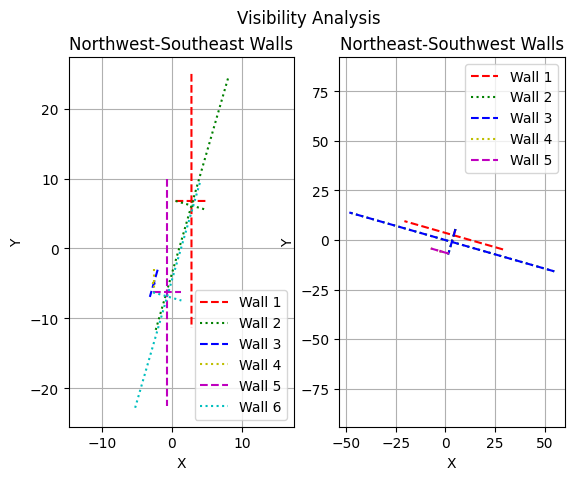

Scene(children=[PolyMesh(data=[], triangle_indices=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  1…

In [13]:
from math import isclose
import matplotlib.pyplot as plt

n_walls, e_walls, s_walls, w_walls = [], [], [], []
n_walls_vertices, e_walls_vertices, s_walls_vertices, w_walls_vertices = [], [], [], []
vectorsNS=[]
vectorsWE=[]
color=['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']
styles=['dashed',  'dotted']

for i in range(0, len(wallsNS2D), 6):
    x1, y1, x2, y2, x3, y3 = wallsNS2D[i], wallsNS2D[i+1], wallsNS2D[i+2], wallsNS2D[i+3], wallsNS2D[i+4], wallsNS2D[i+5]
    x=min(x1, x2, x3)
    if x1==x:
        y=y1
        dx = max(x2, x3)-x1
        dy = max(y2, y3)-y1
    elif x2==x:
        y=y2
        dx = max(x1, x3)-x2
        dy = max(y1, y3)-y2
    else:
        y=y3
        dx = max(x1, x2)-x3
        dy = max(y1, y2)-y3
    vectorsNS.append([x, y, dx, dy])
    
for i in range(0, len(wallsWE2D), 6):
    x1, y1, x2, y2, x3, y3 = wallsWE2D[i], wallsWE2D[i+1], wallsWE2D[i+2], wallsWE2D[i+3], wallsWE2D[i+4], wallsWE2D[i+5]
    if (x1 != x2):
        dx = x2-x1
        dy = y2-y1
    else:
        dx = x3-x1
        dy = y3-y1
    vectorsWE.append([x1, y1, dx, dy])

def intersection(s1 , s2):
    m1, c1 = s1
    m2, c2 = s2

    if m1 == m2:
        return None
    else:
        x= (c2-c1)/(m1-m2)
        y= m1*x+c1
        return (x, y)
    
""" for i in range(len(vectorsNS)):
    x1, y1, dx, dy = vectorsNS[i]
    vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)

    for othervectors in vectorsNS:
        ox1, oy1, odx, ody = othervectors
        if (ox1 == x1 and oy1 == y1 and odx == dx and ody == dy):
            continue
        s2= (ody/odx, oy1-ody/odx*ox1)
        if intersection(straight, s2) == None:
            continue
        else:
            intersectionpoint = intersection(straight, s2)
            if isclose(intersectionpoint[0], xmid, rel_tol=1e-3) and isclose(intersectionpoint[1] , ymid, rel_tol=1e-3):
                continue
            elif(intersectionpoint[0] >= min(ox1,ox1+odx) and intersectionpoint[0] <= max(ox1,ox1+odx) and intersectionpoint[1] >= min(oy1,oy1+ody) and intersectionpoint[1] <= max(oy1,oy1+ody) and min(oy1,oy1+ody)>=min(y1,y1+dy)):
                s_walls_vertices.append(ns_walls[0].vertices[i*9: i*9+9])             
                break

            else:
                n_walls_vertices.append(ns_walls[0].vertices[i*9: i*9+9])
                break

num_rows = len(vectorsWE)
num_cols=1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5,20))

for i in range(len(vectorsWE)):
    x1, y1, dx, dy = vectorsWE[i]
    vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)
    #print (i, x1, y1, dx, dy, straight)
    #print(xmid, ymid)
    for othervectors in vectorsWE:
        ox1, oy1, odx, ody = othervectors
        axs[i].plot([ox1, ox1+odx], [oy1, oy1+ody])
        
        if (ox1 == x1 and oy1 == y1 and odx == dx and ody == dy):
            continue
        s2= (ody/odx, oy1-ody/odx*ox1)
        #print(i, ox1, oy1, odx, ody, s2)
        axs[i].plot(intersection(straight, s2)[0], intersection(straight, s2)[1], 'ro')
        if intersection(straight, s2) == None:
            continue
        else:
            intersectionpoint = intersection(straight, s2)
            #print(intersectionpoint)
            if isclose(intersectionpoint[0], xmid, rel_tol=1e-3) and isclose(intersectionpoint[1] , ymid, rel_tol=1e-3):
                print("same wall")
                continue
            elif(intersectionpoint[0] >= min(ox1,ox1+odx) and intersectionpoint[0] <= max(ox1,ox1+odx) and intersectionpoint[1] >= min(oy1,oy1+ody) and intersectionpoint[1] <= max(oy1,oy1+ody) and min(ox1,ox1+odx)>=min(x1,x1+dx)):
                w_walls_vertices.append(we_walls[0].vertices[i*9: i*9+9])
                print("e walls")
                break
            else:
                print("w walls")
                e_walls_vertices.append(we_walls[0].vertices[i*9: i*9+9])
                break 


    axs[i].plot([x1, x1+dx], [y1, y1+dy], 'r+')
    axs[i].plot(xmid, ymid, 'bo') 
    axs[i].axis('equal')

    print("")

plt.show()"""

def check_triangle_exists(array, triangle):
    for i in range(0, len(array),9):
        current_triangle = array[i:i+9]
        if np.array_equal(current_triangle,triangle):
            return True
    return False

plt.subplot(1,2,1)
for i in range(len(vectorsNS)):
    x1, y1, dx, dy = vectorsNS[i]
    vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)
    straightmax = (vector90, (y1+dy)- vector90*(x1+dx)-0.02)
    straightmin = (vector90, y1- vector90*x1+0.02)
    plt.plot([x1, x1+dx], [y1, y1+dy], color[i%len(color)], label=f"Wall {i+1}", linestyle=styles[i%2])
    plt.plot([xmid-(dy*4), xmid+(dy*4)], [ymid-(-dx*4), ymid+(-dx*4)], color[i%len(color)], linestyle=styles[i%2])   
    if check_triangle_exists(n_walls_vertices, ns_walls[0].vertices[i*9: i*9+9]) or check_triangle_exists(s_walls_vertices, ns_walls[0].vertices[i*9: i*9+9]):
            #print("Triangle already exists")
            continue
    
    for j in range(i+1, len(vectorsNS)):
        ox1, oy1, odx, ody = vectorsNS[j]
        s2= (ody/odx, oy1-ody/odx*ox1)
        #plt.plot([ox1, ox1+odx], [oy1, oy1+ody], color[j%len(color)], label=f"Wall J {j+1}")
        if intersection(straight, s2) == None:
            continue
        elif isclose(intersection(straight, s2)[0], xmid, rel_tol=1e-2) and isclose(intersection(straight, s2)[1],ymid,rel_tol=1e-2):
            #print("Same wall")
            continue
        elif intersection(straight, s2)[1]>ymid and intersection(straight,s2)[0]<=max(ox1, ox1+odx) and intersection(straight,s2)[0]>=min(ox1,ox1+odx): #if there is a wall further north
            #print("wall further north: ",i, i+j, xmid, ymid, intersection(straight, s2))
            s_walls_vertices.extend(ns_walls[0].vertices[i*9: i*9+9])
            n_walls_vertices.extend(ns_walls[0].vertices[(i+j)*9: (i+j)*9+9])
            continue
        elif intersection(straight, s2)[1]<ymid and intersection(straight,s2)[0]<=max(ox1,ox1+odx) and intersection(straight,s2)[0]>=min(ox1,ox1+odx): #if there is a wall further south
            #print("wall further south: ",i, i+j, xmid, ymid, intersection(straight, s2))
            n_walls_vertices.extend(ns_walls[0].vertices[i*9: i*9+9])
            s_walls_vertices.extend(ns_walls[0].vertices[(i+j)*9: (i+j)*9+9])
            continue
        else:
            if isclose(intersection(straightmax, s2)[1], x1+dx, rel_tol=1e-2) and isclose(intersection(straightmax, s2)[1],y1+dy,rel_tol=1e-2) or isclose(intersection(straightmin, s2)[0], x1, rel_tol=1e-2) and isclose(intersection(straightmin, s2)[1],y1,rel_tol=1e-2):
                #print("Same wall")
                continue
            elif intersection(straightmax, s2)[1]>xmid and intersection(straightmax,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmax,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmax, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmax, s2)[1]<xmid and intersection(straightmax,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmax,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmax, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[1]>xmid and intersection(straightmin,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmin,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmin, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[1]<xmid and intersection(straightmin,s2)[0]<=max(ox1, ox1+odx) and intersection(straightmin,s2)[0]>=min(ox1, ox1+odx):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmin, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            else:
                #print("No intersection")
                continue

    #print ("")
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Northwest-Southeast Walls")
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.subplot(1,2,2)
for i in range(len(vectorsWE)):
    x1, y1, dx, dy = vectorsWE[i]
    vector90= -dx/dy
    xmid, ymid = x1+dx/2, y1+dy/2
    straight = (vector90, ymid - vector90*xmid)
    straightmax = (vector90, (y1+dy)- vector90*(x1+dx)+0.02)
    straightmin = (vector90, y1- vector90*x1-0.02)
    plt.plot([x1, x1+dx], [y1, y1+dy], color[i%len(color)], label=f"Wall {i+1}", linestyle=styles[i%2])
    plt.plot([xmid-(dy*4), xmid+(dy*4)], [ymid-(-dx*4), ymid+(-dx*4)], color[i%len(color)], linestyle=styles[i%2])   
    if check_triangle_exists(w_walls_vertices, we_walls[0].vertices[i*9: i*9+9]) or check_triangle_exists(e_walls_vertices, we_walls[0].vertices[i*9: i*9+9]):
            #print("Triangle already exists")
            continue
    
    for j in range(len(vectorsWE)):
        if i==j:
            continue
        ox1, oy1, odx, ody = vectorsWE[j]
        s2= (ody/odx, oy1-ody/odx*ox1)
        if intersection(straight, s2) == None:
            continue
        elif isclose(intersection(straight, s2)[0], xmid, rel_tol=1e-2) and isclose(intersection(straight, s2)[1],ymid,rel_tol=1e-2):
            #print("Same wall")
            continue
        elif intersection(straight, s2)[0]>xmid and intersection(straight,s2)[1]<=max(oy1, oy1+ody) and intersection(straight,s2)[1]>=min(oy1,oy1+ody):
            #print("wall further east: ",i, j, xmid, ymid, intersection(straight, s2))
            w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
            e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            continue
        elif intersection(straight, s2)[0]<xmid and intersection(straight,s2)[1]<=max(oy1,oy1+ody) and intersection(straight,s2)[1]>=min(oy1,oy1+ody):
            #print("wall further west: ",i, j, xmid, ymid, intersection(straight, s2))
            e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
            w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            continue
        else:
            if isclose(intersection(straightmax, s2)[0], x1+dx, rel_tol=1e-2) and isclose(intersection(straightmax, s2)[1],y1+dy,rel_tol=1e-2) or isclose(intersection(straightmin, s2)[0], x1, rel_tol=1e-2) and isclose(intersection(straightmin, s2)[1],y1,rel_tol=1e-2):
                #print("Same wall")
                continue
            elif intersection(straightmax, s2)[0]>xmid and intersection(straightmax,s2)[1]<=max(oy1, oy1+ody) and intersection(straightmax,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmax, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmax, s2)[0]<xmid and intersection(straightmax,s2)[1]<=max(oy1,oy1+ody) and intersection(straightmax,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmax, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[0]>xmid and intersection(straightmin,s2)[1]<=max(oy1, oy1+ody) and intersection(straightmin,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further east: ",i, j, xmid, ymid, intersection(straightmin, s2))
                w_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                e_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
                continue
            elif intersection(straightmin, s2)[0]<xmid and intersection(straightmin,s2)[1]<=max(oy1,oy1+ody) and intersection(straightmin,s2)[1]>=min(oy1,oy1+ody):
                #print("wall further west: ",i, j, xmid, ymid, intersection(straightmin, s2))
                e_walls_vertices.extend(we_walls[0].vertices[i*9: i*9+9])
                w_walls_vertices.extend(we_walls[0].vertices[(j)*9: (j)*9+9])
            else:
                #print("No intersection")
                continue

    #print ("")

plt.xlabel('X')
plt.ylabel('Y')
plt.title("Northeast-Southwest Walls")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.suptitle("Visibility Analysis")
plt.show()

#print(w_walls_vertices)

n_walls.append(PolyMesh(vertices=n_walls_vertices, triangle_indices=range(len(n_walls_vertices)*3)))
s_walls.append(PolyMesh(vertices=s_walls_vertices, triangle_indices=range(len(s_walls_vertices)*3)))
w_walls.append(PolyMesh(vertices=w_walls_vertices, triangle_indices=range(len(w_walls_vertices)*3)))
e_walls.append(PolyMesh(vertices=e_walls_vertices, triangle_indices=range(len(e_walls_vertices)*3)))

walls=Scene(e_walls)
walls

## Upload images from the building